# Loan Application EDA Project
**Objective:** Analyze loan application data to identify patterns in customer profiles, application characteristics, and risk indicators.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 50)

In [ ]:
# Data path configuration
DATA_PATH = '/content/drive/MyDrive/Data Science/TalentLabs/Module 5 EDA Project/Content/Project Dataset (Option 1)/'

# Load datasets
app_data = pd.read_csv(DATA_PATH + 'application_data.csv')
prev_app = pd.read_csv(DATA_PATH + 'previous_application.csv')

print(f"Application Data: {app_data.shape[0]:,} rows, {app_data.shape[1]} columns")
print(f"Previous Application: {prev_app.shape[0]:,} rows, {prev_app.shape[1]} columns")

Application Data: 307,511 rows, 122 columns
Previous Application: 521,277 rows, 37 columns


## 1. Data Quality Assessment

In [ ]:
# Missing value analysis
def missing_summary(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    summary = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
    summary = summary[summary['Missing'] > 0].sort_values('Percent', ascending=False)
    print(f"\n{name}: {len(summary)} columns with missing values")
    return summary.head(15)

print("TOP MISSING VALUE COLUMNS")
print("="*50)
display(missing_summary(app_data, 'Application Data'))
display(missing_summary(prev_app, 'Previous Application'))

TOP MISSING VALUE COLUMNS

Application Data: 67 columns with missing values


,Missing,Percent
COMMONAREA_MEDI,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35



Previous Application: 16 columns with missing values


,Missing,Percent
RATE_INTEREST_PRIVILEGED,519400,99.64
RATE_INTEREST_PRIMARY,519400,99.64
AMT_DOWN_PAYMENT,277581,53.25
RATE_DOWN_PAYMENT,277581,53.25
NAME_TYPE_SUITE,256276,49.16
DAYS_LAST_DUE,208976,40.09
DAYS_FIRST_DRAWING,208976,40.09
DAYS_FIRST_DUE,208976,40.09
DAYS_TERMINATION,208976,40.09
NFLAG_INSURED_ON_APPROVAL,208976,40.09


In [ ]:
# Drop columns with >40% missing
threshold = 0.4
cols_to_drop = app_data.columns[app_data.isnull().mean() > threshold].tolist()
app_clean = app_data.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with >{threshold*100:.0f}% missing")
print(f"Remaining columns: {app_clean.shape[1]}")

Dropped 49 columns with >40% missing
Remaining columns: 73


In [ ]:
# Data types overview
dtype_summary = app_clean.dtypes.value_counts()
print("\nData Types:")
print(dtype_summary)


Data Types:
int64      41
float64    20
object     12
Name: count, dtype: int64


## 2. Target Variable Analysis

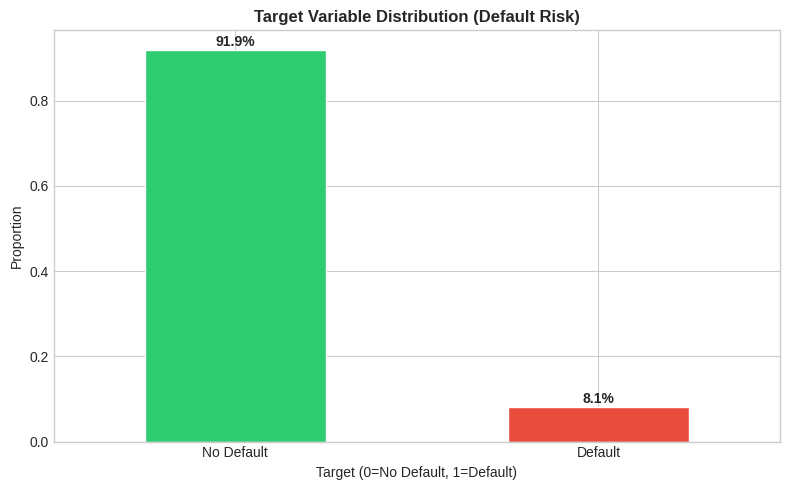


Class Imbalance Ratio: 11.4:1


In [ ]:
# Target distribution (if TARGET column exists)
if 'TARGET' in app_clean.columns:
    target_dist = app_clean['TARGET'].value_counts(normalize=True)

    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ecc71', '#e74c3c']
    target_dist.plot(kind='bar', color=colors, ax=ax, edgecolor='white')
    ax.set_title('Target Variable Distribution (Default Risk)', fontweight='bold')
    ax.set_xlabel('Target (0=No Default, 1=Default)')
    ax.set_ylabel('Proportion')
    ax.set_xticklabels(['No Default', 'Default'], rotation=0)

    for i, v in enumerate(target_dist):
        ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\nClass Imbalance Ratio: {target_dist[0]/target_dist[1]:.1f}:1")

## 3. Numerical Features Analysis

In [ ]:
# Key numerical columns
num_cols = app_clean.select_dtypes(include=[np.number]).columns.tolist()
key_num_cols = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                            'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
                if c in num_cols]

app_clean[key_num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
AMT_INCOME_TOTAL,307511.0,168797.92,237123.15,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599026.00,402490.78,45000.0,270000.0,513531.0,808650.0,4050000.0
AMT_ANNUITY,307499.0,27108.57,14493.74,1615.5,16524.0,24903.0,34596.0,258025.5
AMT_GOODS_PRICE,307233.0,538396.21,369446.46,40500.0,238500.0,450000.0,679500.0,4050000.0
DAYS_BIRTH,307511.0,-16037.00,4363.99,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
DAYS_EMPLOYED,307511.0,63815.05,141275.77,-17912.0,-2760.0,-1213.0,-289.0,365243.0
DAYS_REGISTRATION,307511.0,-4986.12,3522.89,-24672.0,-7479.5,-4504.0,-2010.0,0.0
DAYS_ID_PUBLISH,307511.0,-2994.20,1509.45,-7197.0,-4299.0,-3254.0,-1720.0,0.0


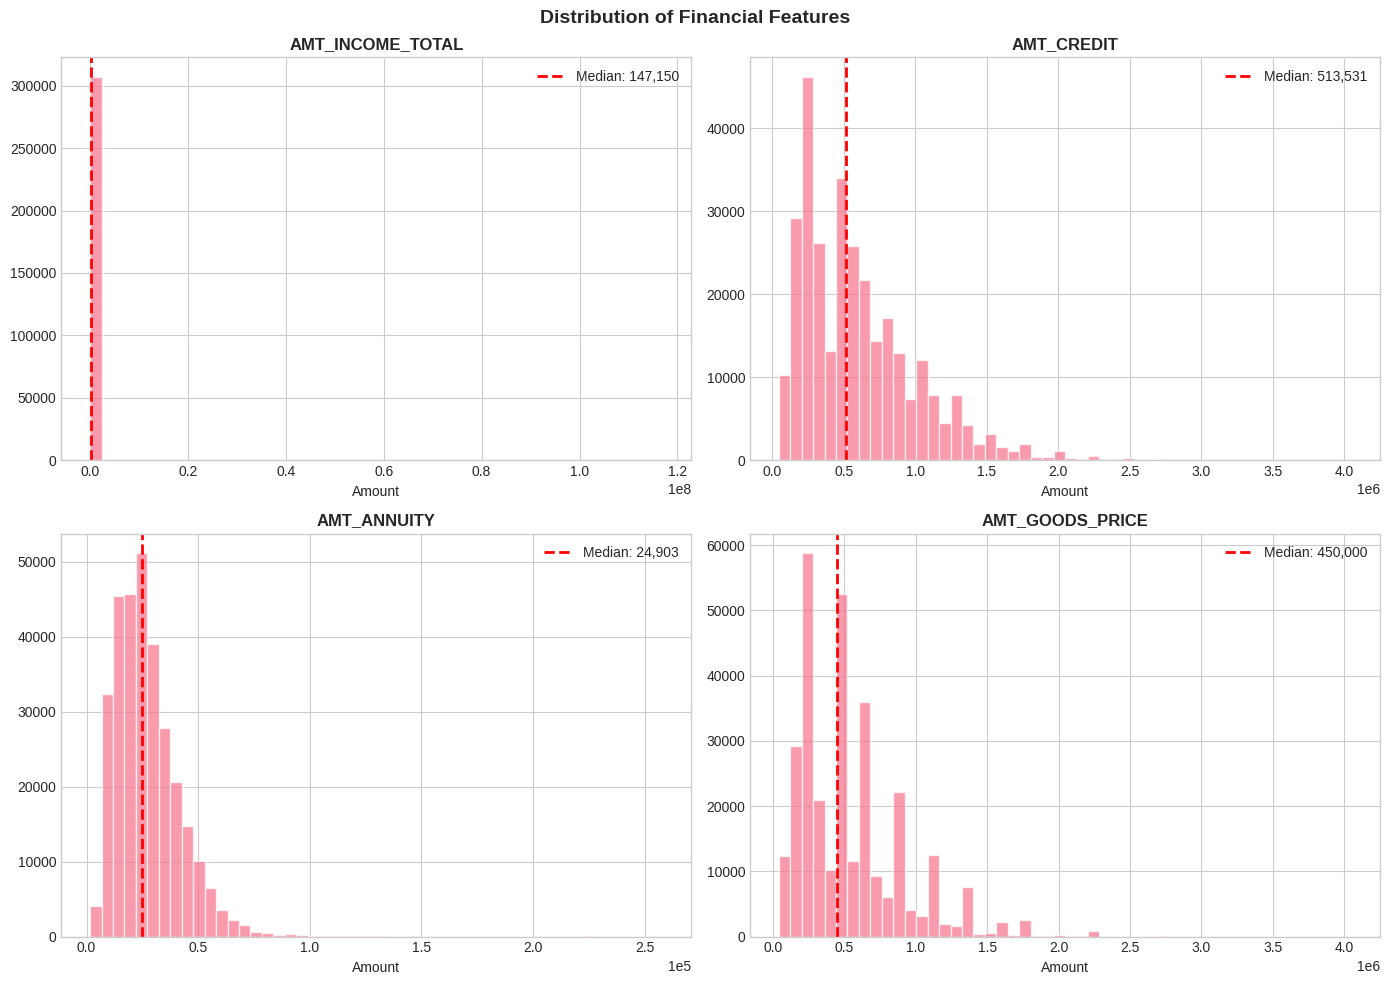

In [ ]:
# Distribution of key financial features
fin_cols = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'] if c in app_clean.columns]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(fin_cols):
    data = app_clean[col].dropna()
    axes[i].hist(data, bins=50, edgecolor='white', alpha=0.7)
    axes[i].axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {data.median():,.0f}')
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('Amount')
    axes[i].legend()
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.suptitle('Distribution of Financial Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

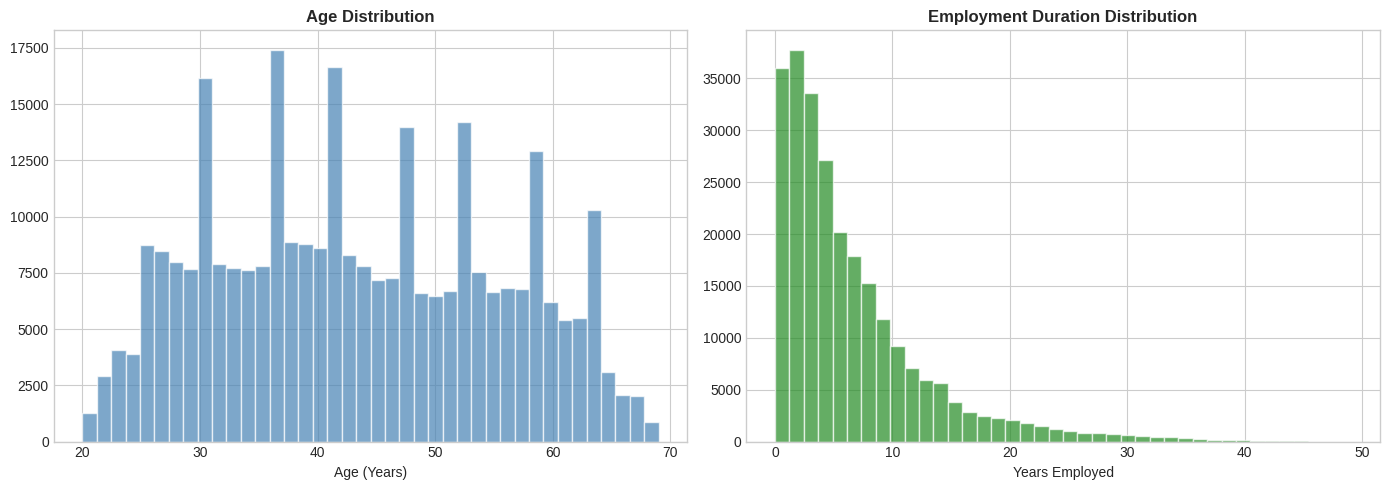

In [ ]:
# Age and employment analysis
if 'DAYS_BIRTH' in app_clean.columns:
    app_clean['AGE_YEARS'] = (-app_clean['DAYS_BIRTH'] / 365).astype(int)

if 'DAYS_EMPLOYED' in app_clean.columns:
    # Handle anomalous values (365243 represents unemployed/pensioner)
    app_clean['EMPLOYMENT_YEARS'] = app_clean['DAYS_EMPLOYED'].apply(
        lambda x: np.nan if x > 0 else -x / 365
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'AGE_YEARS' in app_clean.columns:
    axes[0].hist(app_clean['AGE_YEARS'].dropna(), bins=40, edgecolor='white', alpha=0.7, color='steelblue')
    axes[0].set_title('Age Distribution', fontweight='bold')
    axes[0].set_xlabel('Age (Years)')

if 'EMPLOYMENT_YEARS' in app_clean.columns:
    axes[1].hist(app_clean['EMPLOYMENT_YEARS'].dropna(), bins=40, edgecolor='white', alpha=0.7, color='forestgreen')
    axes[1].set_title('Employment Duration Distribution', fontweight='bold')
    axes[1].set_xlabel('Years Employed')

plt.tight_layout()
plt.show()

## 4. Categorical Features Analysis

In [ ]:
# Key categorical columns analysis
cat_cols = app_clean.select_dtypes(include=['object']).columns.tolist()
key_cat_cols = [c for c in ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                            'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                            'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'] if c in cat_cols]

print(f"Key categorical columns: {len(key_cat_cols)}")
for col in key_cat_cols[:5]:
    print(f"\n{col}: {app_clean[col].nunique()} unique values")

Key categorical columns: 9

NAME_CONTRACT_TYPE: 2 unique values

CODE_GENDER: 3 unique values

FLAG_OWN_CAR: 2 unique values

FLAG_OWN_REALTY: 2 unique values

NAME_INCOME_TYPE: 8 unique values


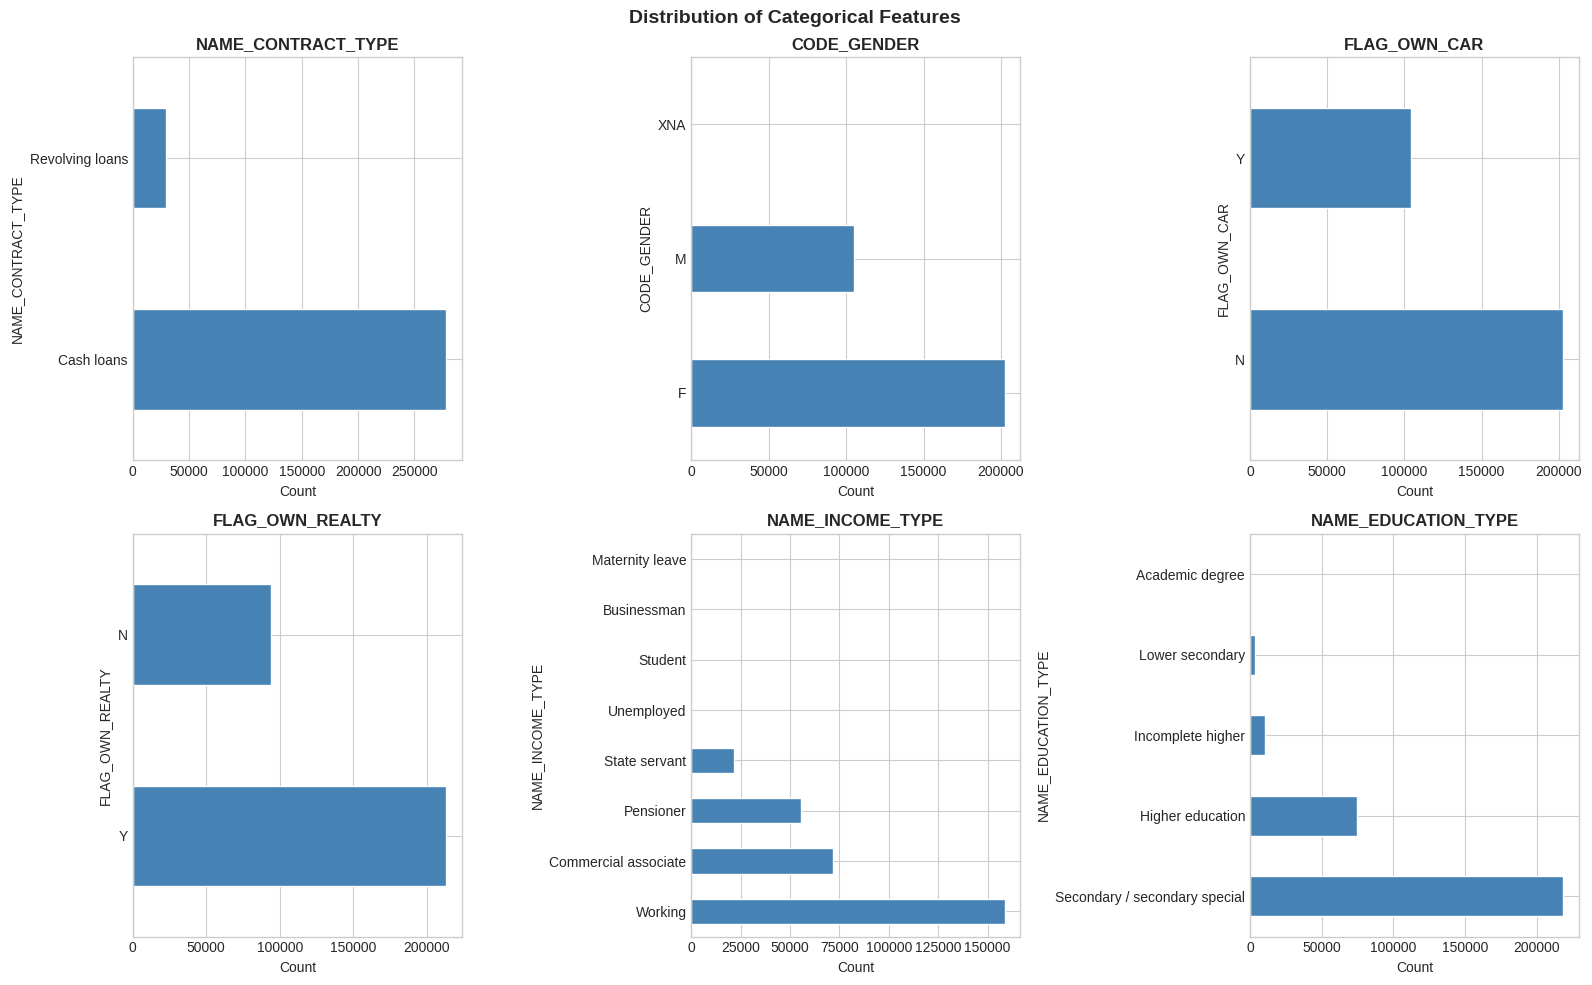

In [ ]:
# Categorical distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

plot_cats = key_cat_cols[:6]

for i, col in enumerate(plot_cats):
    if col in app_clean.columns:
        value_counts = app_clean[col].value_counts().head(8)
        value_counts.plot(kind='barh', ax=axes[i], color='steelblue', edgecolor='white')
        axes[i].set_title(col, fontweight='bold')
        axes[i].set_xlabel('Count')

for j in range(len(plot_cats), len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Categorical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Bivariate Analysis (Target Relationship)

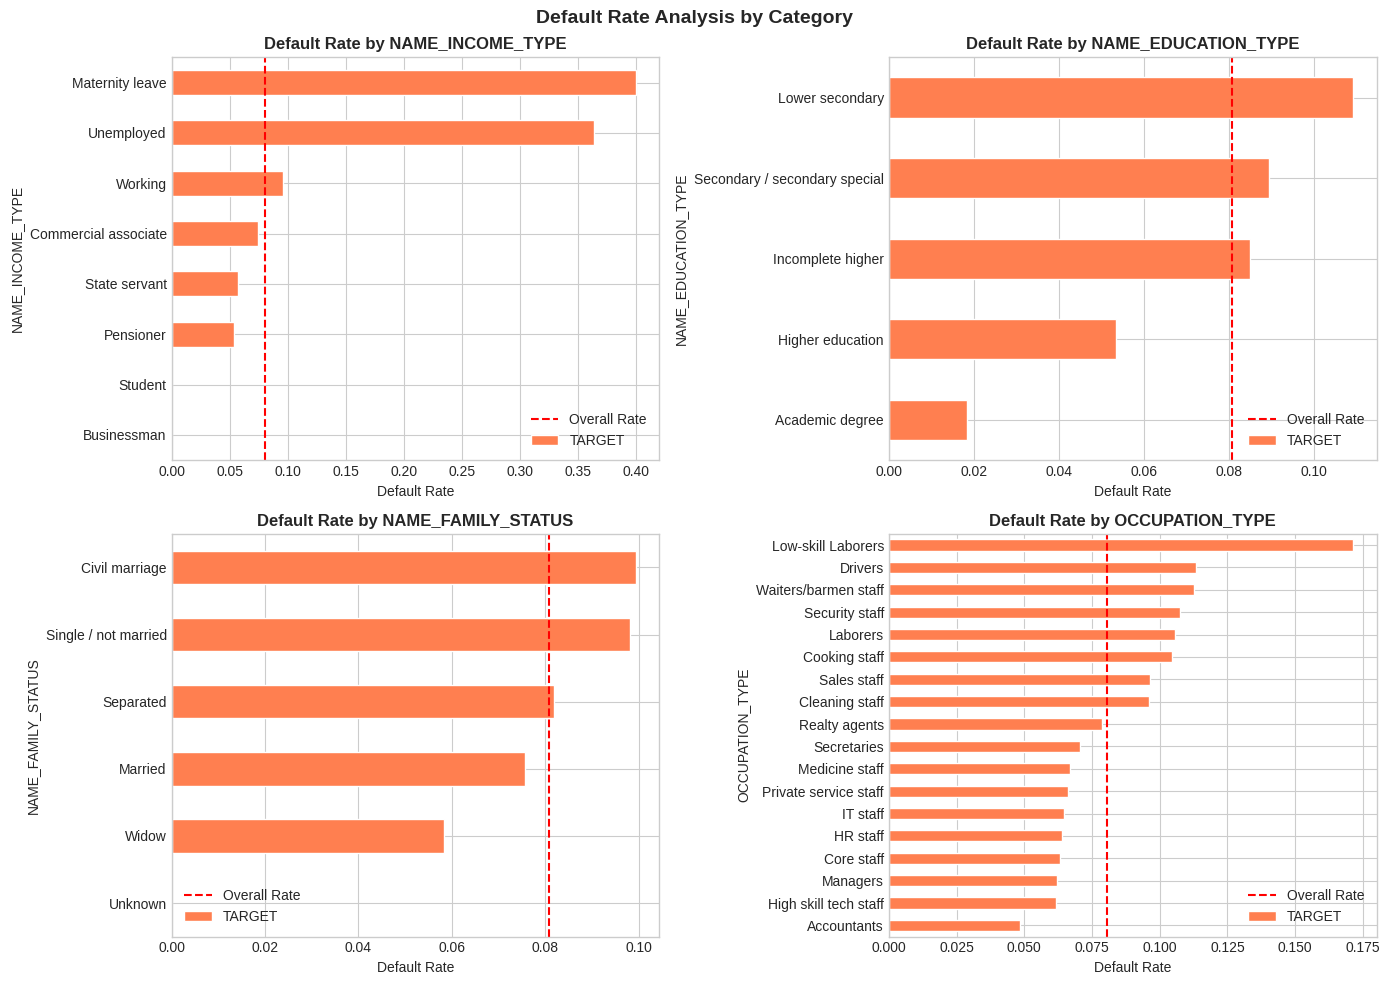

In [ ]:
# Default rate by categorical features
if 'TARGET' in app_clean.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    bivar_cats = [c for c in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
                 if c in app_clean.columns]

    for i, col in enumerate(bivar_cats):
        default_rate = app_clean.groupby(col)['TARGET'].mean().sort_values(ascending=True)
        default_rate.plot(kind='barh', ax=axes[i], color='coral', edgecolor='white')
        axes[i].set_title(f'Default Rate by {col}', fontweight='bold')
        axes[i].set_xlabel('Default Rate')
        axes[i].axvline(app_clean['TARGET'].mean(), color='red', linestyle='--', label='Overall Rate')
        axes[i].legend()

    for j in range(len(bivar_cats), len(axes)):
        axes[j].axis('off')

    plt.suptitle('Default Rate Analysis by Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

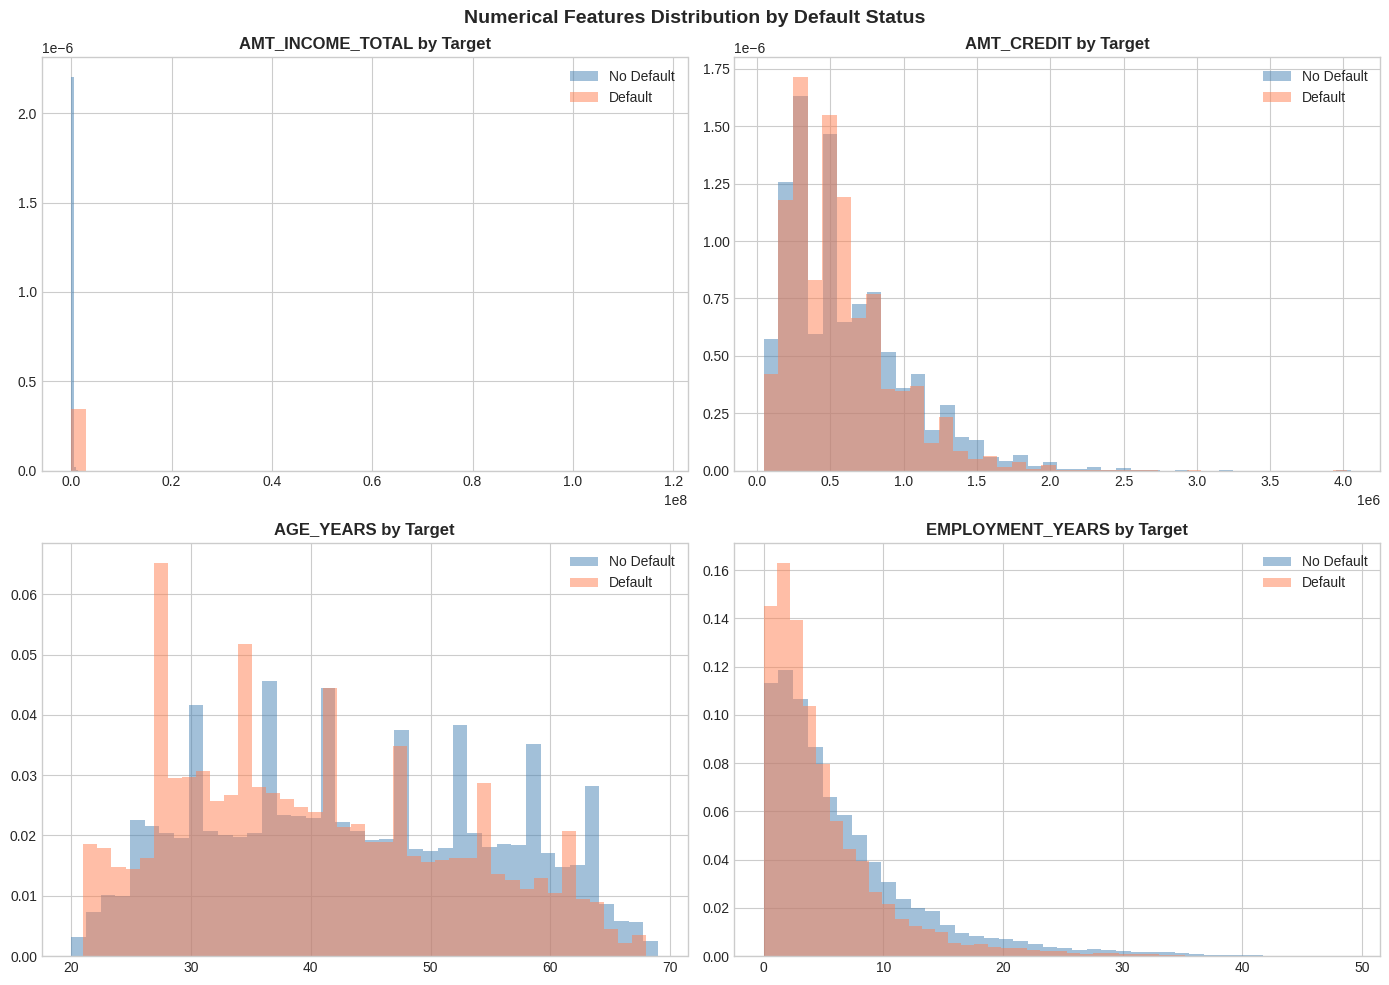

In [ ]:
# Numerical features vs Target
if 'TARGET' in app_clean.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    num_vs_target = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AGE_YEARS', 'EMPLOYMENT_YEARS']
                    if c in app_clean.columns]

    for i, col in enumerate(num_vs_target):
        for target_val, color, label in [(0, 'steelblue', 'No Default'), (1, 'coral', 'Default')]:
            data = app_clean[app_clean['TARGET'] == target_val][col].dropna()
            axes[i].hist(data, bins=40, alpha=0.5, color=color, label=label, density=True)
        axes[i].set_title(f'{col} by Target', fontweight='bold')
        axes[i].legend()

    for j in range(len(num_vs_target), len(axes)):
        axes[j].axis('off')

    plt.suptitle('Numerical Features Distribution by Default Status', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 6. Correlation Analysis

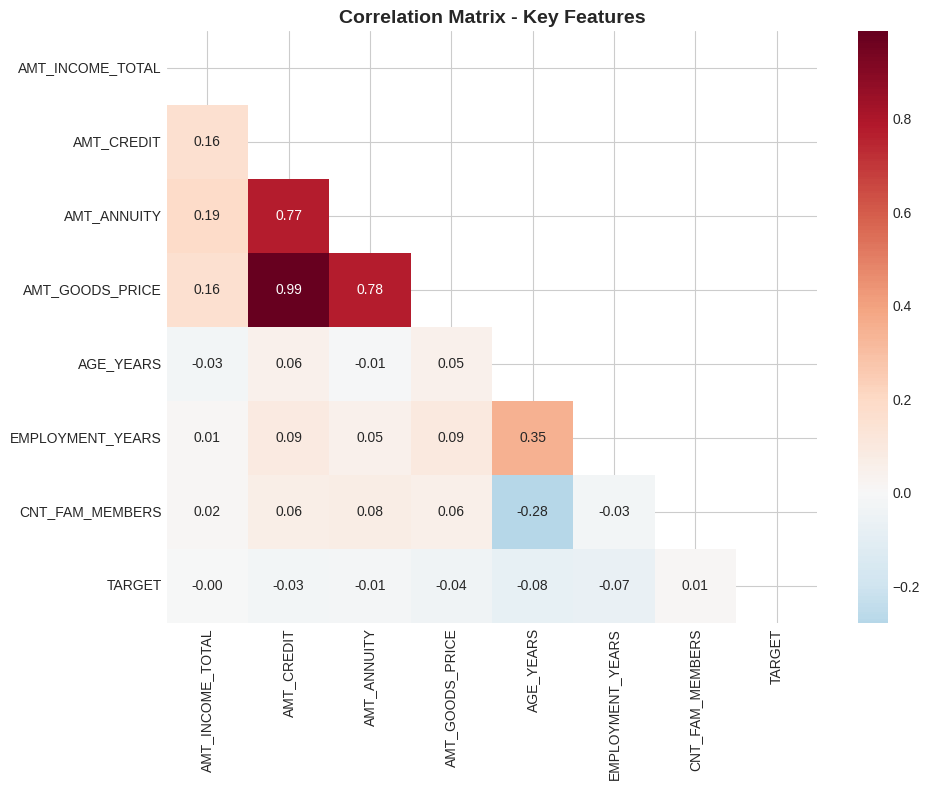

In [ ]:
# Correlation heatmap for key numerical features
corr_cols = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                         'AGE_YEARS', 'EMPLOYMENT_YEARS', 'CNT_FAM_MEMBERS', 'TARGET']
             if c in app_clean.columns]

corr_matrix = app_clean[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax, annot_kws={'size': 10})
ax.set_title('Correlation Matrix - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

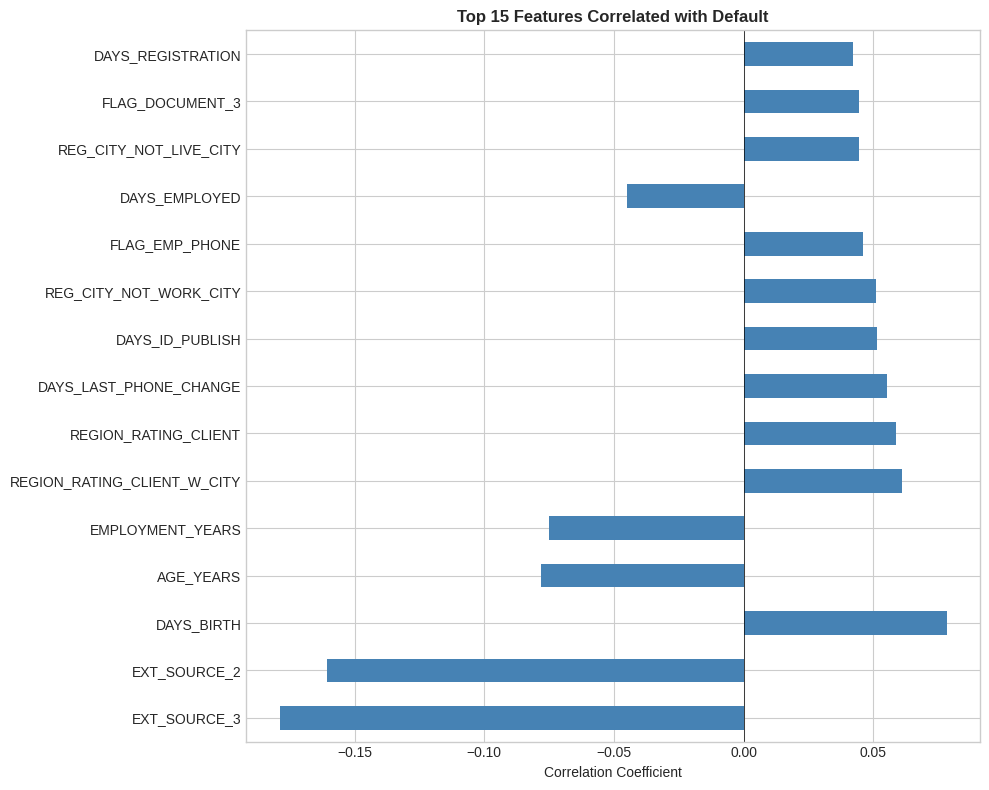

In [ ]:
# Top correlations with target
if 'TARGET' in app_clean.columns:
    num_df = app_clean.select_dtypes(include=[np.number])
    target_corr = num_df.corr()['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    target_corr.head(15).plot(kind='barh', color='steelblue', ax=ax)
    ax.set_title('Top 15 Features Correlated with Default', fontweight='bold')
    ax.set_xlabel('Correlation Coefficient')
    ax.axvline(0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.show()

## 7. Previous Application Analysis

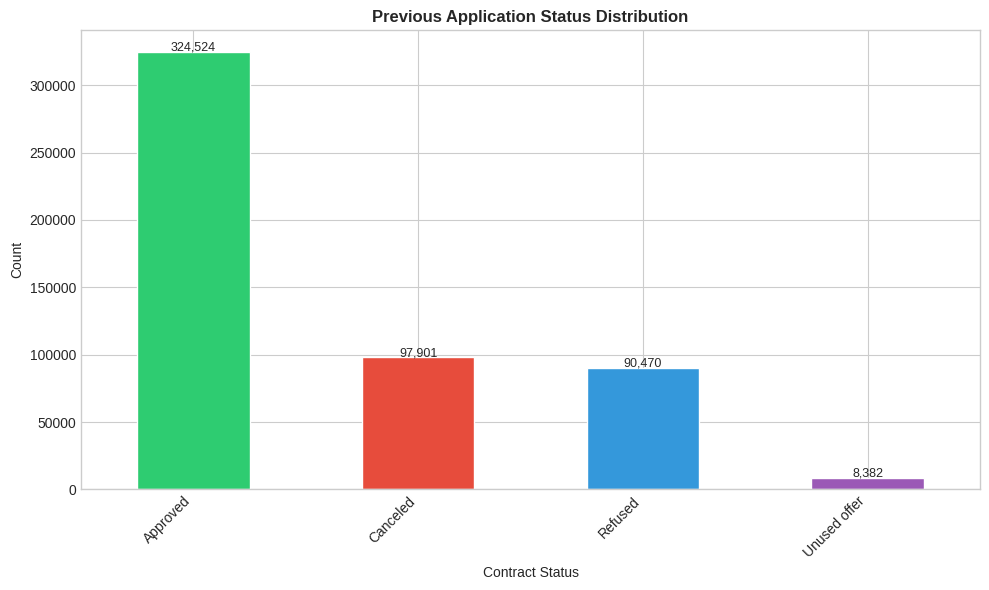

In [ ]:
# Previous application status distribution
if 'NAME_CONTRACT_STATUS' in prev_app.columns:
    status_dist = prev_app['NAME_CONTRACT_STATUS'].value_counts()

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
    status_dist.plot(kind='bar', color=colors[:len(status_dist)], ax=ax, edgecolor='white')
    ax.set_title('Previous Application Status Distribution', fontweight='bold')
    ax.set_xlabel('Contract Status')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for i, v in enumerate(status_dist):
        ax.text(i, v + 1000, f'{v:,}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

In [1]:
# Aggregate previous applications per customer
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',
    'AMT_APPLICATION': ['mean', 'sum'],
    'AMT_CREDIT': ['mean', 'sum']
}).reset_index()

prev_agg.columns = ['SK_ID_CURR', 'PREV_APP_COUNT', 'PREV_AMT_APP_MEAN', 'PREV_AMT_APP_SUM',
                    'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_SUM']

# Merge with main application data
app_merged = app_clean.merge(prev_agg, on='SK_ID_CURR', how='left')
app_merged['PREV_APP_COUNT'] = app_merged['PREV_APP_COUNT'].fillna(0)

print(f"Customers with previous applications: {(app_merged['PREV_APP_COUNT'] > 0).sum():,}")
print(f"Customers without previous applications: {(app_merged['PREV_APP_COUNT'] == 0).sum():,}")

NameError: name 'prev_app' is not defined

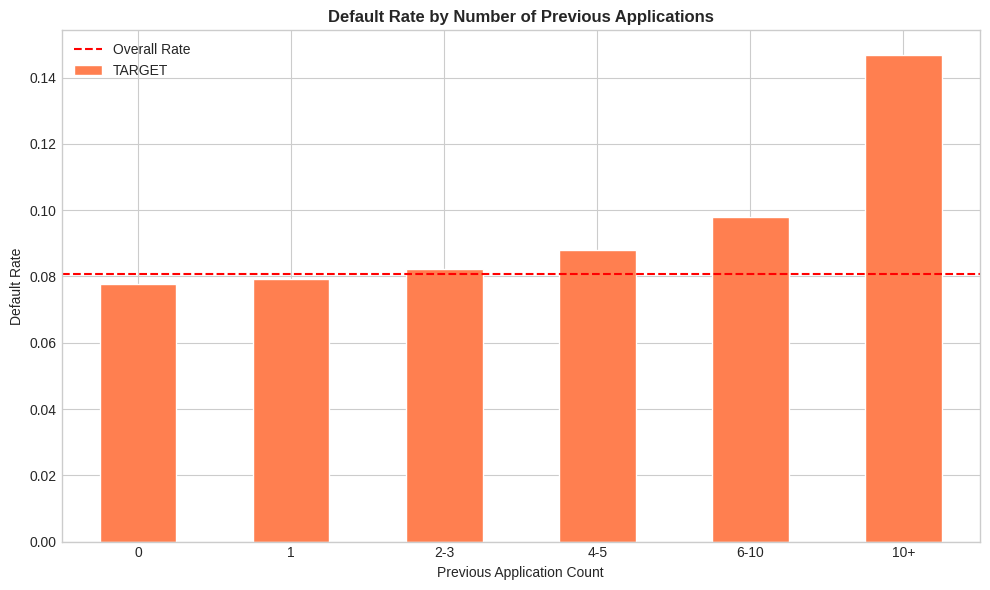

In [ ]:
# Previous application count vs default
if 'TARGET' in app_merged.columns:
    fig, ax = plt.subplots(figsize=(10, 6))

    app_merged['PREV_APP_BINS'] = pd.cut(app_merged['PREV_APP_COUNT'],
                                          bins=[-1, 0, 1, 3, 5, 10, 100],
                                          labels=['0', '1', '2-3', '4-5', '6-10', '10+'])

    default_by_prev = app_merged.groupby('PREV_APP_BINS')['TARGET'].mean()
    default_by_prev.plot(kind='bar', color='coral', ax=ax, edgecolor='white')
    ax.set_title('Default Rate by Number of Previous Applications', fontweight='bold')
    ax.set_xlabel('Previous Application Count')
    ax.set_ylabel('Default Rate')
    ax.axhline(app_merged['TARGET'].mean(), color='red', linestyle='--', label='Overall Rate')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend()
    plt.tight_layout()
    plt.show()

## 8. Key Insights Summary

In [ ]:
# Summary statistics
print("EDA SUMMARY")
print("="*60)
print(f"Total Applications: {len(app_clean):,}")
if 'TARGET' in app_clean.columns:
    print(f"Default Rate: {app_clean['TARGET'].mean():.2%}")
print(f"Features Analyzed: {app_clean.shape[1]}")
print(f"Previous Applications Records: {len(prev_app):,}")

if 'AGE_YEARS' in app_clean.columns:
    print(f"\nAge Range: {app_clean['AGE_YEARS'].min():.0f} - {app_clean['AGE_YEARS'].max():.0f} years")
if 'AMT_CREDIT' in app_clean.columns:
    print(f"Credit Amount Range: {app_clean['AMT_CREDIT'].min():,.0f} - {app_clean['AMT_CREDIT'].max():,.0f}")
if 'AMT_INCOME_TOTAL' in app_clean.columns:
    print(f"Income Range: {app_clean['AMT_INCOME_TOTAL'].min():,.0f} - {app_clean['AMT_INCOME_TOTAL'].max():,.0f}")

EDA SUMMARY
Total Applications: 307,511
Default Rate: 8.07%
Features Analyzed: 75
Previous Applications Records: 521,277

Age Range: 20 - 69 years
Credit Amount Range: 45,000 - 4,050,000
Income Range: 25,650 - 117,000,000


### Key Findings

1. **Class Imbalance:** Significant imbalance between default and non-default cases requires handling during modeling

2. **Income & Credit Relationship:** Strong positive correlation between income and credit amount approved

3. **Employment Impact:** Employment duration shows relationship with default risk - longer employment correlates with lower default

4. **Age Factor:** Age distribution shows middle-aged applicants form the largest segment; younger applicants show higher default rates

5. **Previous History:** Customers with prior applications show different risk profiles - history provides predictive signal

6. **Occupation Risk:** Certain occupation types show significantly higher default rates than others

7. **Education Effect:** Education level correlates with default risk - higher education associated with lower default rates